# Analysing cavitation data

## Libraries

In [262]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Useful functions

In [119]:
def create_dict(keys, values):
    dictionary = dict(zip(keys, values))
    return dictionary

In [145]:
def grouping_pop(df, level, start_rename):    
    df_mean = df.groupby(level).mean().reset_index().dropna(axis = 1)    
    temp_dict = [create_dict(df_mean.columns[start_rename::], df_mean.columns[start_rename::]+ i) for i in ['_mean', '_std']]
    df_mean = df_mean.rename(columns = temp_dict[0])    
    df_std = df.groupby(level).std().reset_index().dropna(axis = 1, thresh=5)    
    df_std= df_std.rename(columns = temp_dict[1])    
    df_n = df.groupby(level).size().reset_index(name='counts')    
    return df_mean, df_std, df_n

In [121]:
def plot_heatmap(cor, mode):
    assert mode in ['cor','abs'], 'mode should be one of ["cor","abs"]'       
    if mode == 'cor':
        vm = -1
    else :
        vm = 0
        cor = np.abs(cor)        
    fig, ax = plt.subplots(figsize=(10, 8))# mask
    mask = np.triu(np.ones_like(cor, dtype=np.bool))# adjust mask and df
    mask = mask[1:, :-1]
    corr = cor.iloc[1:,:-1].copy()# plot heatmap    
    sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", cmap='Blues',
               vmin=vm, vmax=1, cbar_kws={"shrink": .8})# yticks
    plt.yticks(rotation=0)
    plt.show()

In [232]:
def mean_confidence_interval(sm, n, confidence=0.95, verbose = False): 
    '''
    compute the delta to mean value for computing confidence interval
    
    sm : standard deviation of the mean
    n : number of individuals
    
    return the delta to mean value for computing confidence interval (to be added to the mean value)
    '''
    
    def compute_t(confidence, ni):
        t=stats.t.ppf((1 + confidence) / 2., ni-1)
        return t    
    
    tval = [compute_t(confidence, ni) for ni in n]
    n = np.array(n)
    sm = np.array(sm)
    tval = np.array(tval)
    
    h = np.array(sm)/np.sqrt(n) * np.array(tval)
    if verbose:
        print('t values : {}'.format(np.around(tval, decimals=2)))
        print('\nse values : {}'.format(np.around(sm, decimals=2)))
        print('\nci values : {}'.format(np.around(h, decimals=2)))
    return h 


## Importing data

In [122]:
# import df
df = pd.read_table("/home/xavier/Documents/research/FORMANRISK/data/data_formanrisk/individual_join.csv", sep = ";")
df = df.drop(columns = ["X","Y",'X_TYPE_', 'X_FREQ_', 'individual', 'branch_diam', 'branch_diamn','num'])
print('dimensions of df are \nnrows : {0}\nncols : {1}'.format(df.shape[0], df.shape[1]))

dimensions of df are 
nrows : 440
ncols : 50


## Some data cleaning

### Renaming

In [123]:
# remove the _15 from bioclim var
df.columns = [re.sub("_15", "", c) for c in df.columns]

In [124]:
# extracting index of bioclim var
bio_index  = [i for i, item in enumerate(df.columns) if re.search('bio\d{1,2}', item)]

In [125]:
# renaming bioclim var with meaningful names
keys = ["bio1" ,"bio2" ,"bio3" ,"bio4" ,"bio5" ,"bio6" ,"bio7" ,"bio8" ,"bio9" ,"bio10" ,"bio11" ,"bio12" ,"bio13" ,"bio14" ,"bio15" ,"bio16" ,"bio17" ,"bio18" ,"bio19"]
values = ["Tmean_annual" ,"Mean_D_range" ,"Isothermality" ,"T_seasonality" ,"Tmax_warmerM" ,"Tmin_coldestM" ,"T_annual_range" ,"Tmean_wettestQ" ,"Tmean_driestQ" ,"Tmean_warmerQ" ,"Tmean_coldestQ" ,"P_annual" ,"P_wettestM" ,"P_driestM" ,"P_seasonality" ,"P_wettestQ" ,"P_driestQ" ,"P_warmestQ" ,"P_coldestQ"]
dictionary = create_dict(keys,values)
df = df.rename(columns = dictionary)

### summarizing df at pop level

In [146]:
df_pop_mean,df_pop_std,df_pop_n = grouping_pop(df=df, level=['Species','site'], start_rename=2)

In [154]:
# extracting labels of columns of interest
label_num = df_pop_mean.iloc[:,2::].columns

In [161]:
df_pop_mean = pd.concat([df_pop_mean,df_pop_std,df_pop_n], axis = 1)
df_pop_mean =df_pop_mean.loc[:,~df_pop_mean.columns.duplicated()]

### summarizing df at pop level with Treatment

In [163]:
df_pop_mean_T,df_pop_std_T ,df_pop_n_T  = grouping_pop(df=df, level=['Species','site','Treatment'], start_rename=3)

In [164]:
df_pop_mean_T = pd.concat([df_pop_mean_T ,df_pop_std_T ,df_pop_n_T ], axis = 1)
df_pop_mean_T =df_pop_mean_T.loc[:,~df_pop_mean_T.columns.duplicated()]

##  Filter Pinus pinaster populations

In [168]:
df_pp = df[df.Species == "pinus pinaster"]
df_mean_pp = df_pop_mean[df_pop_mean.Species == "pinus pinaster"]
df_mean_pp_T = df_pop_mean_T[df_pop_mean_T.Species == "pinus pinaster"]

## P50 measurements

### Individual level

In [166]:
fig = px.histogram(df_pp,  x="P50", color = 'Treatment', marginal="rug",
                   hover_data=df_pp.columns)
fig.show()

In [167]:
fig = px.box(df_pp, x="site", y="P50", color = 'Treatment')
fig.show()

  Treatment                                     px_fit_results
0     adult  <statsmodels.regression.linear_model.Regressio...
1     young  <statsmodels.regression.linear_model.Regressio...


### Population level

In [252]:
mci = mean_confidence_interval(sm = df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "P50_std"],
                                                  n = df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "counts"],
                              verbose = False)


In [235]:
fig = px.scatter(x=df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='young', "P50_mean"], 
                 y=df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "P50_mean"], 
                 trendline="ols",
                 error_y=mci, 
                 error_y_minus=mci,
                 labels={
                     "x": "P50 mean young",
                     "y": "P50 Mean adult"                     
                 },
                title="adult P50 vs young P50 per population with 95% confidence interval")
fig.show()

## Bioclim / P50 link

### Correlations between variables

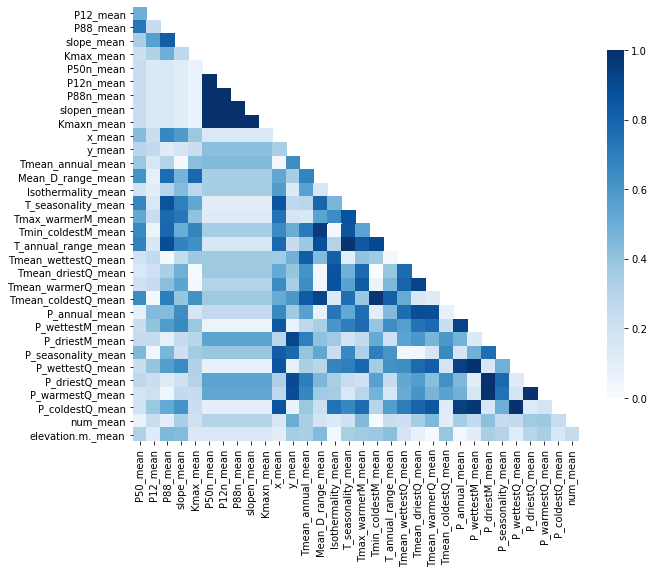

In [239]:
df_corr= df_mean_pp[label_num].corr()
plot_heatmap(cor=df_corr, mode='abs')

### Individual level

In [255]:
import plotly.express as px

fig = px.scatter(df_pp, x="Tmean_annual", y="P50", color="Treatment", trendline="ols", title = 'P50 vs Tmean')
fig.show()

results = px.get_trendline_results(fig)
print(results)

# results.query("Treatment == 'adult'").px_fit_results.iloc[0].summary()
# results.query("Treatment == 'young'").px_fit_results.iloc[0].summary()

  Treatment                                     px_fit_results
0     adult  <statsmodels.regression.linear_model.Regressio...
1     young  <statsmodels.regression.linear_model.Regressio...


### Population level

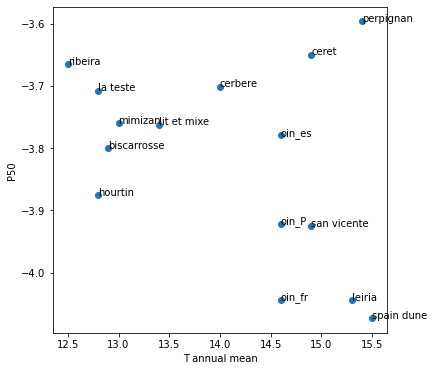

In [240]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_mean_pp['Tmean_annual_mean']/10, df_mean_pp['P50_mean'].values)

for i, txt in enumerate(df_mean_pp['site'].values):
    ax.annotate(txt,  (df_mean_pp['Tmean_annual_mean'][i]/10,df_mean_pp['P50_mean'].values[i]))
plt.ylabel("P50")
plt.xlabel("T annual mean")
plt.show()

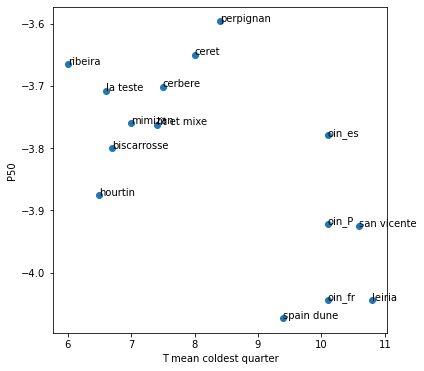

In [307]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_mean_pp['Tmean_coldestQ_mean']/10, df_mean_pp['P50_mean'].values)

for i, txt in enumerate(df_mean_pp['site'].values):
    ax.annotate(txt,  (df_mean_pp['Tmean_coldestQ_mean'][i]/10,df_mean_pp['P50_mean'].values[i]))
plt.ylabel("P50")
plt.xlabel("T mean coldest quarter")
plt.show()

In [294]:
import plotly.express as px

fig = px.scatter(df_mean_pp_T, x="Tmean_annual_mean", y="P50_mean", color="Treatment", trendline="ols", 
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()

results = px.get_trendline_results(fig)
print(results)


  Treatment                                     px_fit_results
0     adult  <statsmodels.regression.linear_model.Regressio...
1     young  <statsmodels.regression.linear_model.Regressio...


In [297]:
import plotly.express as px

fig = px.scatter(df_mean_pp_T, x="P_driestQ_mean", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()


In [295]:
import plotly.express as px

fig = px.scatter(df_mean_pp_T, x="Tmean_warmerQ_mean", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()


In [296]:
import plotly.express as px

fig = px.scatter(df_mean_pp_T, x="Tmin_coldestM_mean", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()


In [306]:
import plotly.express as px

fig = px.scatter(df_mean_pp_T, x="Tmean_coldestQ_mean", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()


## PCA on bioclim var

In [261]:
#instanciations
sc = StandardScaler()
#transformation–centrage-réduction
Z = sc.fit_transform(df_mean_pp_T[[v +'_mean' for v in values]])

In [263]:
#instanciation
acp = PCA(svd_solver='full')
#calculs 
coord = acp.fit_transform(Z)
#nombre de composantes calculées
print(acp.n_components_) 

19


In [275]:
eigval = acp.explained_variance_
#nombre d'observations
n = Z.shape[0]
#nombre de variables
p = Z.shape[1]
print(acp.explained_variance_)

[9.28407553e+00 7.53597642e+00 1.86024489e+00 5.87984293e-01
 2.25137790e-01 1.11597128e-01 3.18263551e-02 1.27372743e-02
 3.95056048e-03 1.29678347e-03 2.71732227e-04 7.36599007e-05
 5.92649257e-32 1.49664944e-32 3.08122525e-33 1.31846998e-33
 1.05366359e-34 4.31741958e-35 1.15075825e-35]


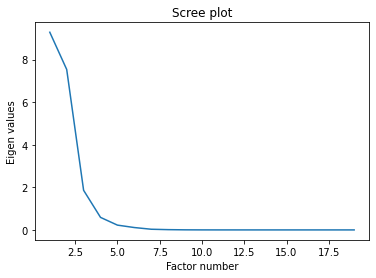

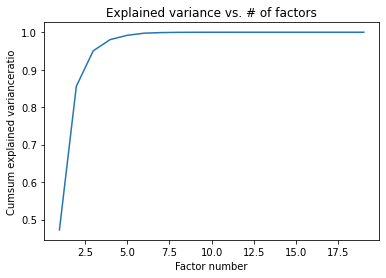

In [273]:
plt.plot(np.arange(1,len(acp.explained_variance_)+1),acp.explained_variance_)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()

plt.plot(np.arange(1,len(acp.explained_variance_)+1),np.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained varianceratio")
plt.xlabel("Factor number")
plt.show()

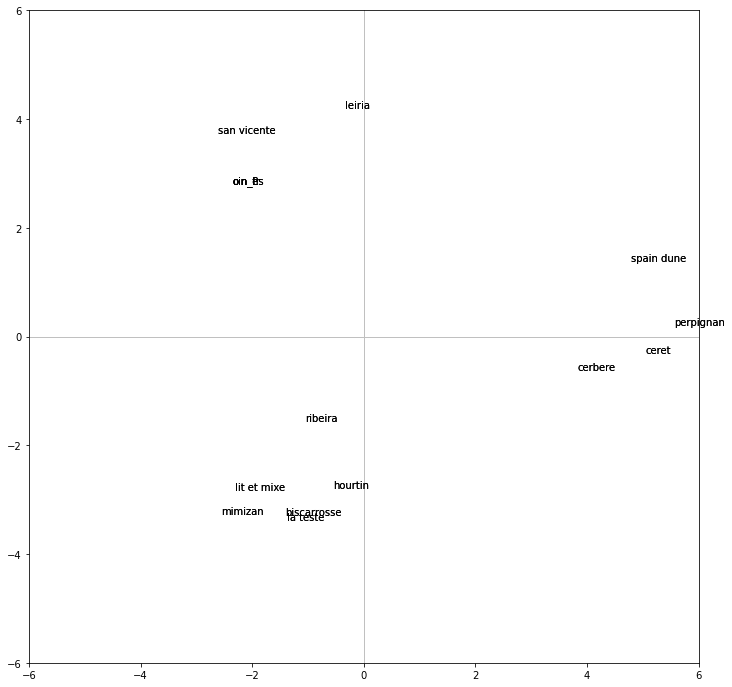

In [274]:
#positionnement des individus dans lepremier plan
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6) #même limites en abscisse
axes.set_ylim(-6,6) #et en ordonnée

#placement des étiquettes des observations
for i in range(n):
    plt.annotate(df_mean_pp_T.site[i],(coord[i,0],coord[i,1]))
#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)#affichage
plt.show()

In [278]:
# racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)


#corrélation des variables avec les axes
corvar = np.zeros((p,p))

for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]
    #afficher la matrice des corrélations variables x facteurs  

# print(corvar)

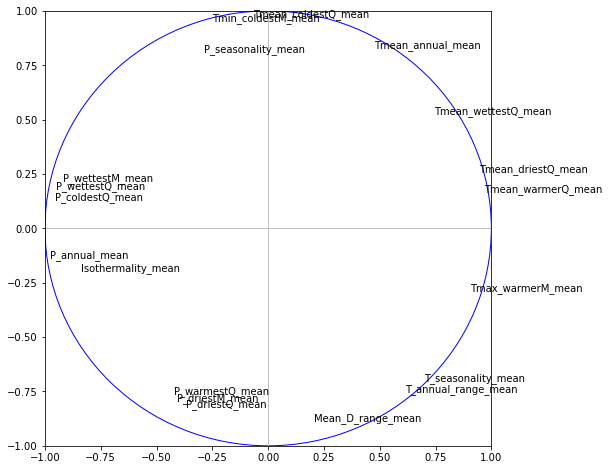

In [285]:
#cercle des corrélations
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
#affichage des étiquettes (noms des variables)
for j in range(p):
    plt.annotate(df_mean_pp_T[[v +'_mean' for v in values]].columns[j],(corvar[j,0],corvar[j,1]))

#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

#affichage
plt.show()


In [304]:
acp_coord = pd.DataFrame(coord, columns = ['acp_'+str(i) for i in np.arange(0,coord.shape[1])])
df_mean_pp_T_acp = pd.concat([df_mean_pp_T, acp_coord], axis = 1)


fig = px.scatter(df_mean_pp_T_acp, x="acp_0", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()


In [305]:
acp_coord = pd.DataFrame(coord, columns = ['acp_'+str(i) for i in np.arange(0,coord.shape[1])])
df_mean_pp_T_acp = pd.concat([df_mean_pp_T, acp_coord], axis = 1)


fig = px.scatter(df_mean_pp_T_acp, x="acp_1", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()
